# Prioritized Experience Replay (PER)


## [기존 Replay Buffer의 문제점]

* **기존 Replay Buffer:**
    * 모든 경험(experience)을 균등한 확률로 무작위 샘플링 (Uniform Random Sampling)
    * **문제점**
      * 비효율성: 모든 경험이 학습에 똑같이 중요하지 않음
        * 어떤 경험은 TD 오차(예측과 실제의 차이)가 매우 큼 -> 학습에 중요!
        * 어떤 경험은 TD 오차가 거의 없음 -> 학습에 별 도움 안 됨
      * 느린 학습속도: 중요한 경험을 충분히 학습에 활용 못함


## [Prioritized Experience Replay (PER)의 핵심 개념: 중요한 경험을 더 많이 사용]

* **목표:** TD 오차가 큰 경험을 "더 많이" 학습 -> 샘플링 효율 극대화, 학습 속도 향상.

* **핵심 아이디어**
  * **TD 오차 활용:** 현재 Q-network의 예측과 실제 target 값의 차이 (TD 오차)를 사용
    * TD 오차 = (실제 target) - (현재 Q-network 예측)  
$ \delta_i = r_i + \gamma \max_{a'} Q(s'_i, a'; \theta^{-}) - Q(s_i, a_i; \theta) $
  * **유용한 경험:** TD 오차가 큰 경험 -> Q-network를 크게 개선할 "잠재력"이 높음 -> 더 자주 학습해야 함!
* **우선순위 할당**
    * **기준:** TD 오차의 절댓값 ($|\delta_i|$) 기반
    * **원리:** TD 오차가 클수록 샘플링 확률 ($\propto$ 우선순위) 증가
    * **수식**
        * $p_i = (|\delta_i| + \epsilon)^\alpha$
            * $p_i$: 경험 $i$의 우선순위 (샘플링 확률에 영향)
            * $\delta_i$: 경험 $i$의 TD 오차
            * $\epsilon$: 작은 양수 (우선순위가 0이 되는 것 방지, 모든 경험이 최소한의 샘플링 확률 보장)
            *   $\alpha$: 우선순위 적용 강도 조절 (0: 균등 샘플링, 1: TD 오차에 비례)
    *   **예시:**
        *   $\alpha = 0.6, \epsilon = 0.001$
        *   TD 오차($\delta$)가 1인 경험 >> TD 오차가 0.1인 경험 (훨씬 높은 확률로 샘플링)

## [중요도 가중치 (Importance Sampling Weight): PER의 편향 잡기]

* **PER의 문제:** "편향(bias)" 발생.
  * TD 오차가 큰 경험만 너무 자주 학습 -> Overfitting 위험
  * TD 오차가 작은 경험은 거의 학습 X -> 놓치는 정보 발생
* **해결:** 중요도 가중치 (Importance Sampling Weight, IS Weight) 사용
  * **목적:** PER로 인한 편향 보정
  * **방법:** 학습 시, 각 경험의 업데이트에 "가중치" 적용
    * TD 오차가 커서 자주 샘플링되는 경험 -> 가중치 낮춤
    * TD 오차가 작아서 드물게 샘플링되는 경험 -> 가중치 높임
  * **수식**: $w_i = \left( \frac{1}{N} \cdot \frac{1}{P(i)} \right)^\beta$
    * $w_i$ : $i$ 번째 transition에 대한 가중치
    * $N$: Replay Buffer의 크기
    * $P(i)$ : $i$ 번째 transition이 sampling 될 확률 ( $ P(i) = \frac{p_i}{\sum_k p_k}$ )
    *   **파라미터:** $\beta$ (0~1)
        *   $\beta = 0$: 보정 X (일반 Replay와 동일)
        *   $\beta = 1$: 완전 보정
        *   **학습 초기:** $\beta$를 작게 시작 -> 점진적으로 1까지 증가 (Annealing)
        *   **이유:** 학습 초기에는 Q-network가 불안정 -> 편향 보정이 오히려 학습 방해 가능성


## [PER의 효과]

*   **빠른 학습 속도**
    *   중요한 경험 집중 학습 -> Q-network 업데이트 효율 증가
    *   불필요한 계산 감소 -> 시간 절약
*   **더 나은 성능**
    *   Overestimation 감소 (TD 오차가 큰 경험을 빠르게 수정)
    *   학습 안정성 향상
*   **샘플 효율성 증가**
    * 적은 수의 sample로 더 좋은 성능을 얻을 수 있음

## [실습: Dueling Double DQN with PER (Prioritized Experience Replay)]

### 1. 라이브러리 가져오기
  *   `gym`: 강화학습 환경 라이브러리
  *   `torch`: PyTorch (신경망 구성 및 훈련)
  *   `numpy`: 수치 연산 및 NumPy 배열 활용
  *   `imageio`: GIF 이미지 생성
  *   `tqdm`: 학습 진행률 표시
  *   `matplotlib`: plotting을 통해 학습 결과 시각화

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### 2. GPU 설정 및 하이퍼파라미터 정의


In [ ]:
# GPU 사용 가능 여부 확인 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터 (CartPole 환경에 맞게 조정)
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
TARGET_UPDATE = 5
MEMORY_SIZE = 30000
LR = 0.0003
NUM_EPISODES = 2000
PROGRESS_INTERVAL = 50

# PER 관련 하이퍼파라미터
ALPHA = 0.6
BETA_START = 0.4
BETA_DECAY = 0.999

### 3. Dueling DQN 네트워크 정의

* Dueling DQN 네트워크를 정의: Value stream과 Advantage stream을 분리하여 Q-value를 계산

In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(DuelingDQN, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, state):
        x = self.feature_layer(state)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

### 4. Prioritized Experience Replay (PER) 구현

* Prioritized Experience Replay를 위한 `PrioritizedReplayBuffer` 클래스를 정의
  * `push`: 새로운 경험(transition)을 buffer에 저장하고, 초기 우선순위(priority)를 최대값으로 설정
      * `states`, `actions`, `rewards`, `next_states`, `dones`: 각 요소를 NumPy 배열로 저장하여, 샘플링 속도 향상
  * `sample`: 우선순위에 따라 경험을 샘플링하고, 중요도 가중치(IS weight)를 함께 반환
      * `priorities`:  `np.array`를 사용하여 우선순위 계산 및 샘플링을 효율적으로 수행
  * `update_priorities`: TD 오차에 따라 샘플링된 경험들의 우선순위를 업데이트

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=ALPHA):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.array(state)
        next_state = np.array(next_state)
        max_priority = max(self.priorities, default=1) # 처음엔 1, 이후엔 max
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=BETA_START):
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalize for stability
        weights = torch.tensor(weights, dtype=torch.float32, device=device)

        state, action, reward, next_state, done = zip(*samples)

        return torch.tensor(np.array(state), dtype=torch.float32, device=device), \
               torch.tensor(action, dtype=torch.int64, device=device), \
               torch.tensor(reward, dtype=torch.float32, device=device), \
               torch.tensor(np.array(next_state), dtype=torch.float32, device=device), \
               torch.tensor(done, dtype=torch.float32, device=device), \
               weights, indices # 중요도 가중치, 샘플링된 인덱스 반환

    def update_priorities(self, indices, errors, offset=0.1):
        for idx, error in zip(indices, errors):
            self.priorities[idx] = (abs(error) + offset) ** self.alpha

    def __len__(self):
        return len(self.buffer)

### 5. 학습 함수 정의

* 설명: Dueling Double DQN with PER 알고리즘으로 에이전트를 학습
  * Epsilon-Greedy: `epsilon` 값을 점차 감소시켜 탐험과 활용의 균형을 맞춤
  * Double DQN: Target Q-value 계산 시, Double DQN 방식을 사용 (Overestimation 완화)
    * `policy_net`으로 다음 상태의 행동 선택, `target_net`으로 Q-value 계산
  * Prioritized Experience Replay
    * TD 오차 계산 후, `replay_buffer.update_priorities`를 호출하여 우선순위를 업데이트
    * `replay_buffer.sample`에서 반환된 중요도 가중치(`weights`)를 loss 계산에 반영
  * 학습 진행률: `tqdm`을 사용하여 시각적으로 표시

In [ ]:
def train(env, policy_net, target_net, optimizer, replay_buffer, num_episodes=NUM_EPISODES):
    all_rewards = []
    epsilon = EPS_START
    beta = BETA_START
    for episode in tqdm(range(num_episodes), desc="Training"):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-Greedy Action Selection
            if random.random() > epsilon:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax(dim=1).item()
            else:
                action = env.action_space.sample()

            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated

            # Replay Buffer에 경험 저장
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state

            # Replay Buffer에서 샘플링 및 학습
            if len(replay_buffer) >= BATCH_SIZE:
                state_batch, action_batch, reward_batch, next_state_batch, done_batch, weights, indices = replay_buffer.sample(BATCH_SIZE, beta)

                # Double DQN Target Q-value 계산
                with torch.no_grad():
                    next_actions = policy_net(next_state_batch).argmax(dim=1, keepdim=True)
                    next_q_values = target_net(next_state_batch).gather(1, next_actions).squeeze(1)
                    target_q_values = reward_batch + (1 - done_batch) * GAMMA * next_q_values

                # 현재 Q-value 계산
                q_values = policy_net(state_batch)
                q_values_for_actions = q_values.gather(1, action_batch.unsqueeze(1)).squeeze(1)

                # Loss 계산 및 최적화
                errors = (target_q_values - q_values_for_actions).detach().cpu().numpy()
                replay_buffer.update_priorities(indices, errors) # update priorities
                loss = (weights * (q_values_for_actions - target_q_values)**2).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Target Network 업데이트
        if (episode+1) % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # epsilon, beta 업데이트
        epsilon = max(EPS_END, epsilon * EPS_DECAY)
        beta = min(1.0, beta * BETA_DECAY)

        # 평균 리워드 출력
        all_rewards.append(total_reward)
        if (episode+1) % PROGRESS_INTERVAL == 0:
            print(f"Episode {episode+1}: Average Reward = {np.mean(all_rewards[-PROGRESS_INTERVAL:])}")

        # 오랜 기간 리워드가 충분히 크다면 학습 종료
        if np.min(all_rewards[-TARGET_UPDATE*2:]) >= 450:
            print(f"Solved in {episode+1} episodes!")
            break

    return all_rewards

### 6. 학습 실행 및 결과 확인

Training:   3%|▎         | 51/2000 [00:08<06:17,  5.17it/s]

Episode 50: Average Reward = 27.52


Training:   5%|▌         | 100/2000 [00:23<09:17,  3.41it/s]

Episode 100: Average Reward = 50.72


Training:   8%|▊         | 150/2000 [00:42<10:35,  2.91it/s]

Episode 150: Average Reward = 55.6


Training:  10%|█         | 200/2000 [01:15<18:20,  1.64it/s]

Episode 200: Average Reward = 89.44


Training:  12%|█▎        | 250/2000 [02:05<38:10,  1.31s/it]

Episode 250: Average Reward = 114.56


Training:  15%|█▌        | 300/2000 [03:01<42:24,  1.50s/it]

Episode 300: Average Reward = 113.38


Training:  18%|█▊        | 350/2000 [04:23<55:10,  2.01s/it]

Episode 350: Average Reward = 141.38


Training:  20%|██        | 400/2000 [06:13<38:40,  1.45s/it]

Episode 400: Average Reward = 168.92


Training:  22%|██▎       | 450/2000 [08:33<1:59:55,  4.64s/it]

Episode 450: Average Reward = 218.8


Training:  25%|██▌       | 500/2000 [12:14<2:22:00,  5.68s/it]

Episode 500: Average Reward = 355.84


Training:  28%|██▊       | 550/2000 [15:57<1:14:46,  3.09s/it]

Episode 550: Average Reward = 344.56


Training:  30%|███       | 600/2000 [19:10<2:04:54,  5.35s/it]

Episode 600: Average Reward = 309.68


Training:  32%|███▎      | 650/2000 [22:30<1:47:21,  4.77s/it]

Episode 650: Average Reward = 322.32


Training:  35%|███▌      | 700/2000 [26:07<1:39:18,  4.58s/it]

Episode 700: Average Reward = 347.04


Training:  38%|███▊      | 750/2000 [29:52<1:51:12,  5.34s/it]

Episode 750: Average Reward = 357.04


Training:  38%|███▊      | 756/2000 [30:36<50:22,  2.43s/it]  

Solved in 757 episodes!


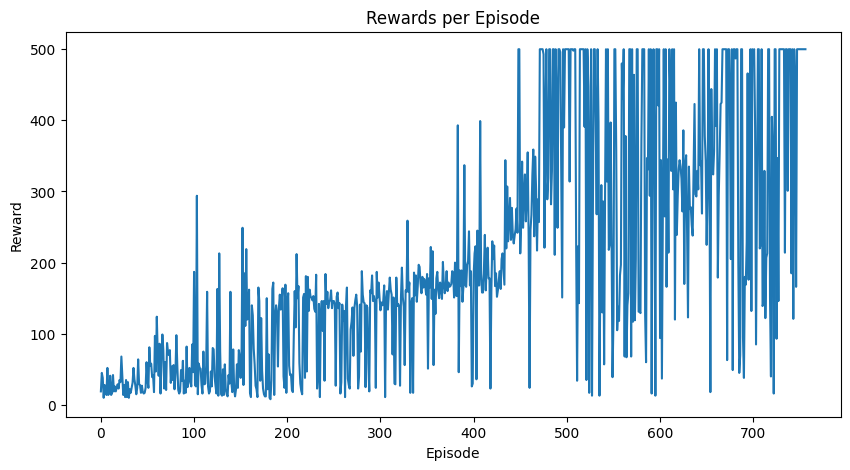

In [ ]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
hidden_size = 128

policy_net = DuelingDQN(state_size, action_size, hidden_size).to(device)
target_net = DuelingDQN(state_size, action_size, hidden_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = PrioritizedReplayBuffer(MEMORY_SIZE)

all_rewards = train(env, policy_net, target_net, optimizer, replay_buffer)

# 학습 결과 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(all_rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [ ]:
# 최종 결과 플레이 렌더링 및 GIF로 저장
frames = []
state, _ = env.reset()
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = policy_net(state_tensor)
        action = q_values.argmax(dim=1).item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    state = next_state
    done = terminated or truncated
    frames.append(env.render())

imageio.mimsave('cartpole_dueling_double_dqn_per.gif', frames, duration=33)
print(f"Validation Episode Reward: {total_reward}")
env.close()

Validation Episode Reward: 500.0
